In [39]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from glob import glob
from tqdm import tqdm
from tifffile import imread, imsave
from csbdeep.utils import Path, normalize
from csbdeep.utils.plot_utils import *
from csbdeep.data.transform import Transform

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.models.sample_patches import sample_patches
from stardist.models.model2d import SampleX2D

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

from one_cycle_lr.lr_finder import *

np.random.seed(42)
lbl_cmap = random_label_cmap()

%reload_ext autoreload
%autoreload 2

1.14.0


In [2]:
# import os
# os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'
# import gputools
# print(gputools_available())

## Load sample data

In [3]:
X = sorted(glob('/home/qzt/data/centuri/train/images/*.tif'))
Y = sorted(glob('/home/qzt/data/centuri/train/masks/*.tif'))
# X = sorted(glob('/home/qzt/data/dsb2018_sub1/images/*.tif'))
# Y = sorted(glob('/home/qzt/data/dsb2018_sub1/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
X[0]

'/home/qzt/data/centuri/train/images/V1a-DMSO-x40-E1-2.tif'

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))

n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 5/5 [00:00<00:00, 53.78it/s]


In [5]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

#manual assign train/val index for debugging
ind_train = [1,2,3,4]
ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:   5
- training:         4
- validation:       1


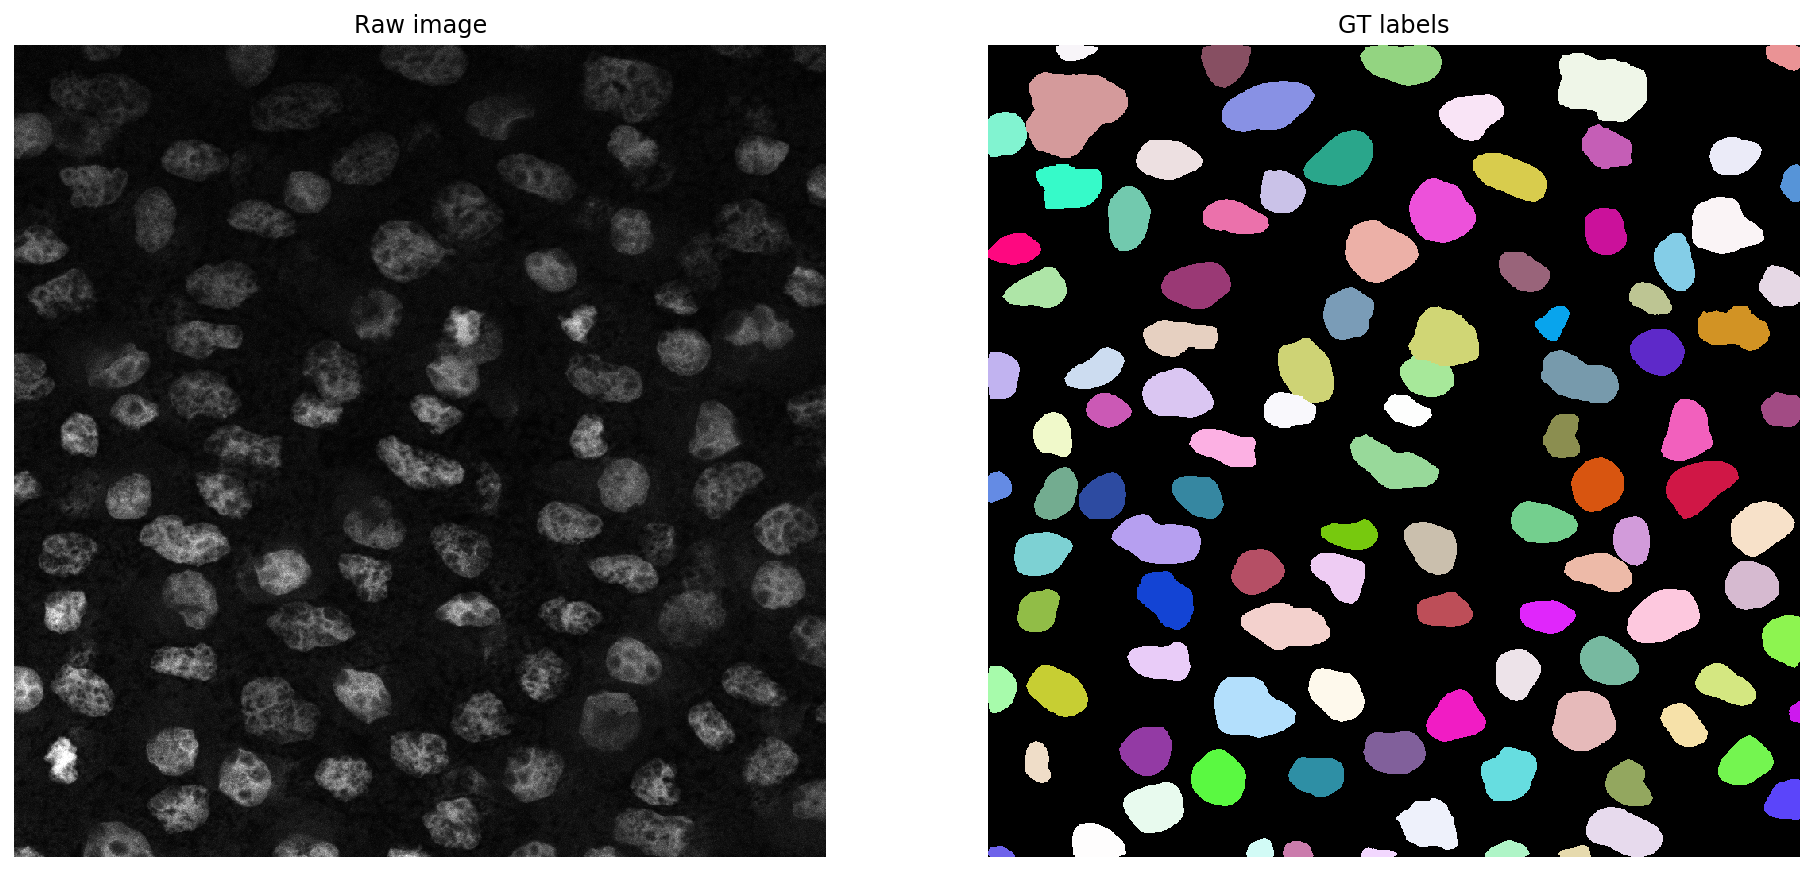

In [6]:
i = 0
img, lbl = X[i], Y[i]
img, lbl = X_val[0], Y_val[0]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [7]:
img.shape

(1022, 1022)

In [8]:
# # 32 is a good default choice (see 1_data.ipynb)
# n_rays = 32

# # Use OpenCL-based computations for data generator during training (requires 'gputools')
# use_gpu = True and gputools_available()

# # Predict on subsampled grid for increased efficiency and larger field of view
# grid = (2,2)

# conf = Config2D (
#     n_rays       = n_rays,
#     grid         = grid,
#     use_gpu      = use_gpu,
#     n_channel_in = n_channel,
#     train_batch_size = 4,  #no gpu
#     train_epochs = 400,
#     train_steps_per_epoch = 100,
#     train_one_cycle_lr_max = 0.003,
#     y_range = None
# #     unet_batch_norm=True,
# #     train_learning_rate=0.0003  #(3e-3)
    
# #     net_input_shape = (X_trn[0].shape[0], X_trn[0].shape[1], n_channel)
# )

# conf

## Load trained model

In [9]:
model = StarDist2D(None, name='stardist_depth_3_augment_True_grid_2_2_epochs_800', basedir='../../models')
# load weights into current model in h5 format (keras)
model.keras_model.load_weights("../../models/stardist_depth_3_augment_True_grid_2_2_epochs_800/weights_last.h5")
print("Loaded model from disk")

/home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as Activation) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Loaded model from disk


In [10]:
model.config

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], norm_by_mask=True, train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=800, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=[1, 0.2], train_n_val_patches=None, train_one_cycle_lr_max=None, train_patch_size=[256, 256], train_reduce_lr={'factor': 0.5, 'patience': 80, 'min_delta': 0}, train_shape_completion=False, train_steps_per_epoch=400, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=[3, 3], unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=[2, 2], unet_prefix='', use_gpu=False, y_rang

In [11]:
model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 3 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

## Prepare a model to take output from intermediate layer

In [12]:
km = model.keras_model
for index in np.arange(0,len(km.layers)):
    layer=km.get_layer(index=index)
    print("{}_{}".format(index,layer.name))

0_input
1_conv2d_1
2_conv2d_2
3_max_pooling2d_1
4_down_level_0_no_0
5_down_level_0_no_1
6_max_0
7_down_level_1_no_0
8_down_level_1_no_1
9_max_1
10_down_level_2_no_0
11_down_level_2_no_1
12_max_2
13_middle_0
14_middle_2
15_up_sampling2d_1
16_concatenate_1
17_up_level_2_no_0
18_up_level_2_no_2
19_up_sampling2d_2
20_concatenate_2
21_up_level_1_no_0
22_up_level_1_no_2
23_up_sampling2d_3
24_concatenate_3
25_up_level_0_no_0
26_up_level_0_no_2
27_features
28_prob
29_dist


In [13]:
from keras.models import Model
layer_model = Model(inputs=km.input, outputs=km.layers[26].output)

## prepare inputs (fixed patch size) from the dsb2018 training images
Larger images might need to be sampled multiple times ?

In [81]:
def iter_seq(seq, n_iter):
    n = 0
    while n<n_iter:
        for item in seq:
            n = n+1
            yield item

In [15]:
# X = sorted(glob('/home/qzt/data/centuri/train/images/*.tif'))
# Y = sorted(glob('/home/qzt/data/centuri/train/masks/*.tif'))
X = sorted(glob('/home/qzt/data/dsb2018/train/images/*.tif'))
# Y = sorted(glob('/home/qzt/data/dsb2018/train/masks/*.tif'))

X_file = [os.path.split(f)[-1] for f in X]
# assert all(Path(x).name==Path(y).name for x,y in zip(X,Y_file))
print(X_file[0])

00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.tif


In [16]:
X = list(map(imread,X))
# Y = list(map(imread,Y))

print(len(X))
print(len(X_file))

axis_norm = (0,1) # normalized Y and X
ptl_low = 1
ptl_high = 99.8
X = [normalize(x, ptl_low, ptl_high, axis=axis_norm) for x in tqdm(X)]
# Y = [fill_label_holes(y) for y in tqdm(Y)]

 17%|█▋        | 74/447 [00:00<00:00, 733.84it/s]

447
447


100%|██████████| 447/447 [00:00<00:00, 758.86it/s]


### Test the helper Class: SampleX2D

In [17]:
bs = 8

data_train = SampleX2D(X, batch_size=bs, shuffle=False, patch_size=(256,256), augmenter=None, shape_completion=False)

In [18]:
imgs, names = data_train[0]
type(imgs)

numpy.ndarray

In [19]:
imgs.shape

(8, 256, 256, 1)

In [20]:
dummy = np.empty(imgs.shape, np.float32)
dummy.shape

(8, 256, 256, 1)

In [21]:
hidden_output = layer_model.predict([imgs, dummy])
hidden_output.shape

(8, 128, 128, 32)

In [22]:
n1 = np.array(names)
n1.ndim

1

In [23]:
ho1 = hidden_output.reshape((hidden_output.shape[0], -1))
ho1.shape

(8, 524288)

In [24]:
ho2 = np.c_[n1,ho1]
ho2.shape

(8, 524289)

In [25]:
ho2[:, :4]

array([[0.        , 0.84810555, 0.14435929, 0.31091964],
       [1.        , 0.94014716, 0.25193673, 0.26129407],
       [2.        , 0.83921909, 0.25264174, 0.32710183],
       [3.        , 0.95693028, 0.31659263, 0.19759843],
       [4.        , 0.49104393, 0.        , 0.        ],
       [5.        , 0.85933888, 0.1926951 , 0.2531715 ],
       [6.        , 1.1039784 , 0.33986276, 0.16785476],
       [7.        , 0.40740341, 0.19440733, 0.23157185]])

### verify seq will yield different patches when iterated over

In [82]:
rep = 2
seq = iter_seq(data_train, rep*len(X)//bs)
# for s in seq:
#     print(s[1])
imgs, idx =  zip(*[(s[0], s[1]) for s in seq])

['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.tif', '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1.tif', '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21.tif', '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426.tif', '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339.tif', '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776.tif', '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe.tif', '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a.tif']
[0, 1, 2, 3, 4, 5, 6, 7]


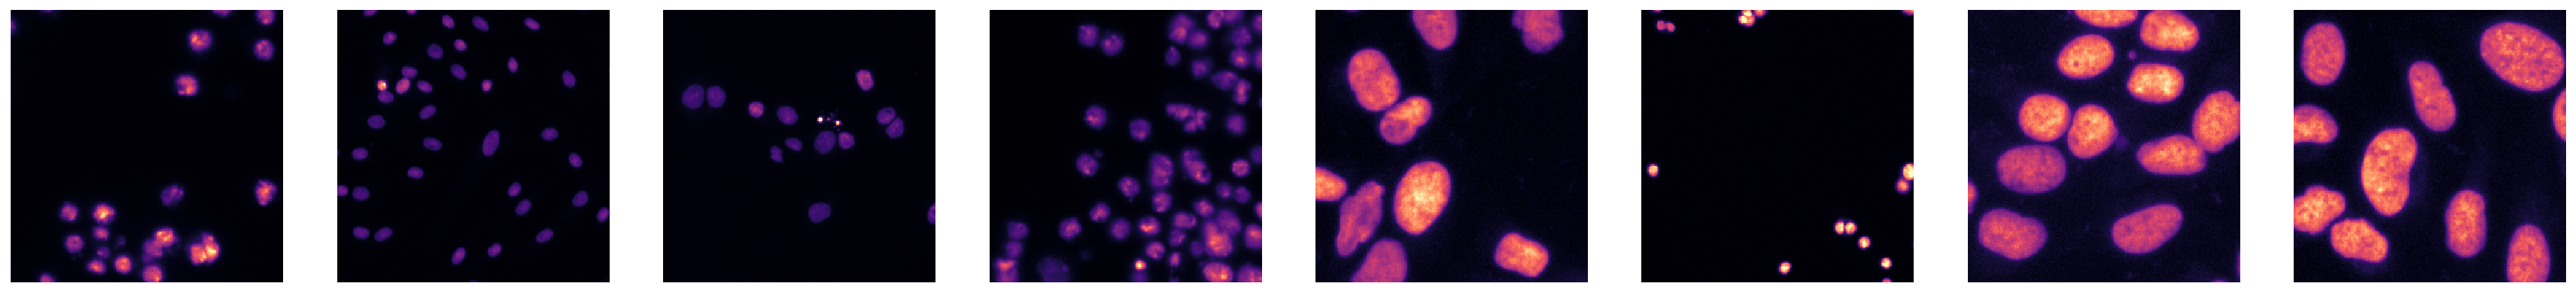

In [27]:
i = 0
plot_some(imgs[i], x_inch=30, y_inch=20)
print([X_file[j] for j in idx[i]])
print(idx[i])

['08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada.tif', '094afe36759e7daffe12188ab5987581d405b06720f1d5acf3f2614f404df380.tif', '0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9.tif', '0acd2c223d300ea55d0546797713851e818e5c697d073b7f4091b96ce0f3d2fe.tif', '0c6507d493bf79b2ba248c5cca3d14df8b67328b89efa5f4a32f97a06a88c92c.tif', '0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c.tif', '0ddd8deaf1696db68b00c600601c6a74a0502caaf274222c8367bdc31458ae7e.tif', '0e5edb072788c7b1da8829b02a49ba25668b09f7201cf2b70b111fc3b853d14f.tif']
[16, 17, 18, 19, 20, 21, 22, 23]


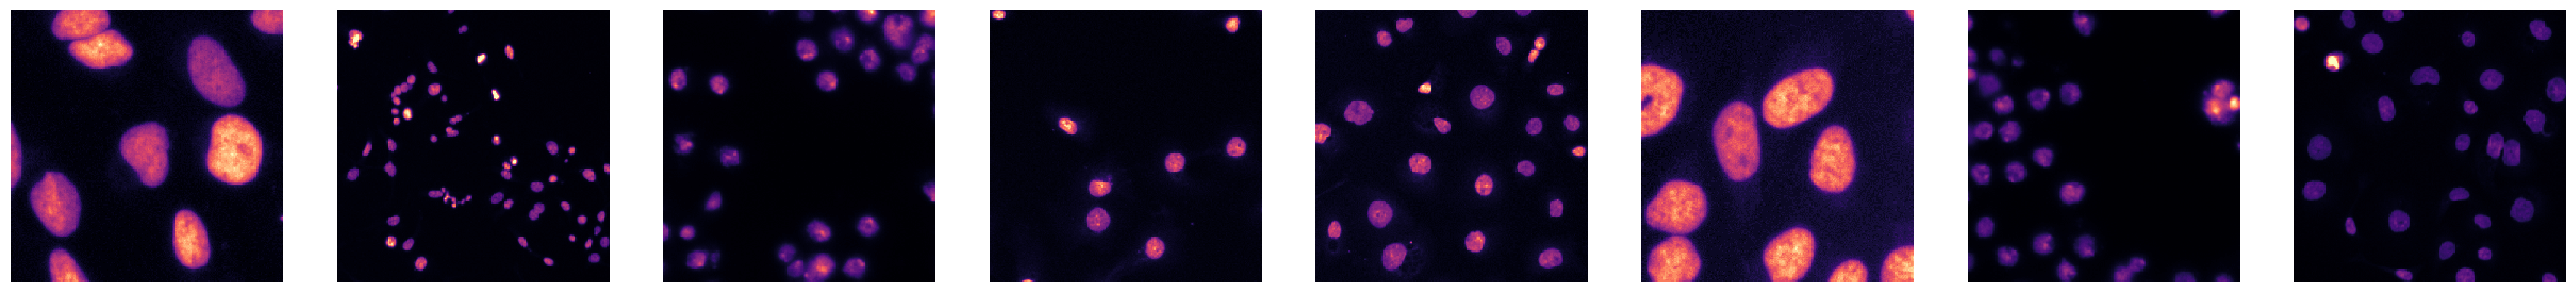

In [28]:
i = 2
plot_some(imgs[i], x_inch=30, y_inch=20)
print([X_file[j] for j in idx[i]])
print(idx[i])

### test saving the sampled patches for later inspection

In [36]:
imgs1 = np.squeeze(imgs[0], axis=-1)
imgs1.shape

(8, 256, 256)

In [41]:
counter = 0
for img in imgs1:
    imsave(f'patches/dsb_{counter:03}.tif', img)
    counter +=1

### feed the iterated patches into the layer model
And save the sampled patches

In [91]:
def save_patches(images, f_names, prefix="patches/"):
#     assert len(images) == len(f_names)
    images = np.squeeze(images, axis=-1)  #remove the unused channel dimension
    for g, n in zip(images, f_names):
        imsave(f'{prefix}_{n:04}.tif', g)

In [92]:
#iterator need to be called again
rep = 2
seq = iter_seq(data_train, rep*len(X)//bs)

outputs = []
counter = 0
prefix="patches/dsb"

for s in seq:
    imgs = s[0]
    idx = s[1]
    serial = list(np.arange(counter*bs, (counter+1)*bs))[0:len(idx)]
    dummy = np.empty(imgs.shape, np.float32)
    hidden_output = layer_model.predict([imgs, dummy])
    hidden_output = hidden_output.reshape((hidden_output.shape[0], -1))
    hidden_output = np.c_[serial, idx, hidden_output]
#     hidden_output = np.concatenate((idx, hidden_output), axis=1)
    outputs.append(hidden_output)
#     if outputs is None:
#         outputs = hidden_output
#     else:
#         outputs = np.concatenate((outputs, hidden_output), axis=0)
        
    ## save the patches
    save_patches(imgs, serial, prefix=prefix )

    counter += 1
print(outputs.shape)

[0, 1, 2, 3, 4, 5, 6, 7]
[8, 9, 10, 11, 12, 13, 14, 15]
[16, 17, 18, 19, 20, 21, 22, 23]
[24, 25, 26, 27, 28, 29, 30, 31]
[32, 33, 34, 35, 36, 37, 38, 39]
[40, 41, 42, 43, 44, 45, 46, 47]
[48, 49, 50, 51, 52, 53, 54, 55]
[56, 57, 58, 59, 60, 61, 62, 63]
[64, 65, 66, 67, 68, 69, 70, 71]
[72, 73, 74, 75, 76, 77, 78, 79]
[80, 81, 82, 83, 84, 85, 86, 87]
[88, 89, 90, 91, 92, 93, 94, 95]
[96, 97, 98, 99, 100, 101, 102, 103]
[104, 105, 106, 107, 108, 109, 110, 111]
[112, 113, 114, 115, 116, 117, 118, 119]
[120, 121, 122, 123, 124, 125, 126, 127]
[128, 129, 130, 131, 132, 133, 134, 135]
[136, 137, 138, 139, 140, 141, 142, 143]
[144, 145, 146, 147, 148, 149, 150, 151]
[152, 153, 154, 155, 156, 157, 158, 159]
[160, 161, 162, 163, 164, 165, 166, 167]
[168, 169, 170, 171, 172, 173, 174, 175]
[176, 177, 178, 179, 180, 181, 182, 183]
[184, 185, 186, 187, 188, 189, 190, 191]
[192, 193, 194, 195, 196, 197, 198, 199]
[200, 201, 202, 203, 204, 205, 206, 207]
[208, 209, 210, 211, 212, 213, 214, 215]
[21

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
outputs = np.concatenate(outputs, axis=0)
outputs.shape

In [203]:
outputs[440:480, :1]

array([[440.],
       [441.],
       [442.],
       [443.],
       [444.],
       [445.],
       [446.],
       [  0.],
       [  1.],
       [  2.],
       [  3.],
       [  4.],
       [  5.],
       [  6.],
       [  7.],
       [  8.],
       [  9.],
       [ 10.],
       [ 11.],
       [ 12.],
       [ 13.],
       [ 14.],
       [ 15.],
       [ 16.],
       [ 17.],
       [ 18.],
       [ 19.],
       [ 20.],
       [ 21.],
       [ 22.],
       [ 23.],
       [ 24.],
       [ 25.],
       [ 26.],
       [ 27.],
       [ 28.],
       [ 29.],
       [ 30.],
       [ 31.],
       [ 32.]])

In [204]:
np.save('featurelayer26_output+idx_patch256_rep2_dsb2018_stardistAUG', outputs, allow_pickle=False)

## Prepare inputs from our own datasets (fixed patch size)

In [210]:
X = sorted(glob('/home/qzt/data/centuri/train/images/*.tif'))
X_file = [os.path.split(f)[-1] for f in X]

X = list(map(imread,X))

print(len(X))
print(len(X_file))

axis_norm = (0,1) # normalized Y and X
ptl_low = 1
ptl_high = 99.8
X = [normalize(x, ptl_low, ptl_high, axis=axis_norm) for x in tqdm(X)]

100%|██████████| 5/5 [00:00<00:00, 98.22it/s]

5
5


In [211]:
bs = 5
data_train = SampleX2D(X, batch_size=bs, shuffle=False, patch_size=(256,256), augmenter=None, shape_completion=False)

In [212]:
#iterator need to be called again
rep = 20
seq = iter_seq(data_train, rep*len(X)//bs)

# outputs = np.concatenate([layer_model.predict([s[0][0], np.empty(s[0][0].shape, np.float32)]) for s in seq])
# print(outputs.shape)
outputs = []
counter = 0
prefix="patches/dsb"

for s in seq:
    imgs = s[0]
    idx = s[1]
    serial = list(np.arange(counter*bs, (counter+1)*bs))[0:len(idx)]
    dummy = np.empty(imgs.shape, np.float32)
    hidden_output = layer_model.predict([imgs, dummy])
    hidden_output = hidden_output.reshape((hidden_output.shape[0], -1))
    hidden_output = np.c_[serial, idx, hidden_output]
    outputs.append(hidden_output)

    ## save the patches
    save_patches(imgs, serial, prefix=prefix )

    counter += 1

(100, 524289)


In [ ]:
outputs = np.concatenate(outputs, axis=0)
outputs.shape

In [213]:
np.save('featurelayer26_output+idx_patch256_rep20_centuri_stardistAUG', outputs, allow_pickle=False)

## Resize np array into 2D 
(nsamples * feature(WxHxC)) for PCA or other dimension reduction analysis

In [47]:
centuri_2d = outputs.reshape((100,-1))
centuri_2d.shape

(100, 2097152)

In [1]:
dsb = np.load('featurelayer_output_patch256_rep4_dsb2018_stardistAUG.npy')
dsb.shape

NameError: name 'np' is not defined

## prepare inputs (original size)
But since images in training, validation set have different size, the outputs cannot be compared easily... 

In [15]:
X = sorted(glob('/home/qzt/data/centuri/test/images/*.tif'))
X = list(map(imread,X))
# x2 = np.stack(X);x2.shape
axis_norm = (0,1) # normalized Y and X
img = normalize(X[0], 1,99.8, axis=axis_norm)
img.shape

(1000, 1022)

Reperform the same operation as in the StarDistBase.predict_instance function
assume tile = [1,1], axes = YX, channel = 1, normalization performed beforehand

i.e. :
predict(img, axes='YX', normalizer=None, n_tiles=None)

In [16]:
x_test, dummy = model.prepare_input(img)
x_test.shape, dummy.shape

((1, 1008, 1024, 1), (1, 1008, 1024, 1))

## Feed the input into layer model

In [18]:
hidden_output = layer_model.predict([x_test, dummy])
 
print(hidden_output.shape)

(1, 504, 512, 128)


In [21]:
test = np.concatenate((hidden_output, hidden_output), axis=0)
test.shape

(2, 504, 512, 128)

## Make a loop to get layer outputs

In [23]:
axis_norm = (0,1) # normalized Y and X
ptl_low = 1
ptl_high = 99.8

outputs = None

X = sorted(glob('/home/qzt/data/centuri/test/images/*.tif'))
X = list(map(imread,X))

for xi in X:
    #do normalization
    img = normalize(xi, ptl_low, ptl_high, axis=axis_norm)
    #get padded input
    x_test, dummy = model.prepare_input(img)
    x_test.shape, dummy.shape
    #feed into model 
    hidden_output = layer_model.predict([x_test, dummy])
    if outputs is None:
        outputs = hidden_output
    else:
        outputs = np.concatenate((outputs, hidden_output), axis=0)
print(outputs.shape)

(5, 512, 512, 128)


In [ ]:
prob, dist = self.keras_model.predict([tile[np.newaxis],dummy[np.newaxis]], **predict_kwargs)

In [103]:
AUGMENTATIONS_TRAIN = None
data_train = StarDistData2D(X, Y, batch_size=1, n_rays=32, patch_size=(512,512), augmenter=AUGMENTATIONS_TRAIN, shape_completion=False)
XX , _ = data_train[0] ##each get_item from StarDistData2D will return a tuple of [X,dist_mask], [prob,dist]
img = XX[0]   ## get only the 1st element from the list of [X,dist_mask]
img.shape

AssertionError: 

In [86]:
sh = list(img.shape)
dummy = np.empty(sh,np.float32); dummy.shape

(5, 512, 512, 1)

(5, 256, 256, 128)


In [ ]:
[tile[np.newaxis],dummy[np.newaxis]]

## Debug validation data part

In [27]:
validation_data=(X_val,Y_val)
data_kwargs = {'n_rays': 32, 'patch_size': (256, 256), 'grid': (2, 2), 'shape_completion': False, 'b': 32, 'use_gpu': False, 'foreground_prob': 0.9}
data_val = StarDistData2D(*validation_data, batch_size=1, **data_kwargs)

In [30]:
layer_fea = model.keras_model.get_layer(index=-1)
layer_fea.activation

<function keras.activations.linear(x)>

## Try single prediction

In [34]:
model.thresholds, model.config.grid

(Thresholds(prob=0.479071463157368, nms=0.3), (2, 2))

In [106]:
x3 = np.squeeze(x2)
x3.shape

(1000, 1022)

In [141]:
img = normalize(x3, 1,99.8, axis=(0,1))
img.shape

(1000, 1022)

In [ ]:
%%debug
labels, details = model.predict_instances(img, axes='YX')

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
None
> <string>(2)<module>()



ipdb>  s


--Call--
> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(354)predict_instances()
    352 
    353 
--> 354     def predict_instances(self, img, axes=None, normalizer=None,
    355                           prob_thresh=None, nms_thresh=None,
    356                           n_tiles=None, show_tile_progress=True,



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(399)predict_instances()
    397 
    398         """
--> 399         if predict_kwargs is None:
    400             predict_kwargs = {}
    401         if nms_kwargs is None:



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(400)predict_instances()
    398         """
    399         if predict_kwargs is None:
--> 400             predict_kwargs = {}
    401         if nms_kwargs is None:
    402             nms_kwargs = {}



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(401)predict_instances()
    399         if predict_kwargs is None:
    400             predict_kwargs = {}
--> 401         if nms_kwargs is None:
    402             nms_kwargs = {}
    403 



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(402)predict_instances()
    400             predict_kwargs = {}
    401         if nms_kwargs is None:
--> 402             nms_kwargs = {}
    403 
    404         nms_kwargs.setdefault("verbose", verbose)



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(404)predict_instances()
    402             nms_kwargs = {}
    403 
--> 404         nms_kwargs.setdefault("verbose", verbose)
    405 
    406         _axes         = self._normalize_axes(img, axes)



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(406)predict_instances()
    404         nms_kwargs.setdefault("verbose", verbose)
    405 
--> 406         _axes         = self._normalize_axes(img, axes)
    407         _axes_net     = self.config.axes
    408         _permute_axes = self._make_permute_axes(_axes, _axes_net)



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(407)predict_instances()
    405 
    406         _axes         = self._normalize_axes(img, axes)
--> 407         _axes_net     = self.config.axes
    408         _permute_axes = self._make_permute_axes(_axes, _axes_net)
    409         _shape_inst   = tuple(s for s,a in zip(_permute_axes(img).shape, _axes_net) if a != 'C')



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(408)predict_instances()
    406         _axes         = self._normalize_axes(img, axes)
    407         _axes_net     = self.config.axes
--> 408         _permute_axes = self._make_permute_axes(_axes, _axes_net)
    409         _shape_inst   = tuple(s for s,a in zip(_permute_axes(img).shape, _axes_net) if a != 'C')
    410 



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(409)predict_instances()
    407         _axes_net     = self.config.axes
    408         _permute_axes = self._make_permute_axes(_axes, _axes_net)
--> 409         _shape_inst   = tuple(s for s,a in zip(_permute_axes(img).shape, _axes_net) if a != 'C')
    410 
    411         prob, dist = self.predict(img, axes=axes, normalizer=normalizer, n_tiles=n_tiles, show_tile_progress=show_tile_progress, **predict_kwargs)



ipdb>  


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(411)predict_instances()
    409         _shape_inst   = tuple(s for s,a in zip(_permute_axes(img).shape, _axes_net) if a != 'C')
    410 
--> 411         prob, dist = self.predict(img, axes=axes, normalizer=normalizer, n_tiles=n_tiles, show_tile_progress=show_tile_progress, **predict_kwargs)
    412         return self._instances_from_prediction(_shape_inst, prob, dist, prob_thresh=prob_thresh, nms_thresh=nms_thresh, overlap_label = overlap_label, **nms_kwargs)
    413 



ipdb>  s


--Call--
> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(244)predict()
    242 
    243 
--> 244     def predict(self, img, axes=None, normalizer=None, n_tiles=None, show_tile_progress=True, **predict_kwargs):
    245         """Predict.
    246 



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(274)predict()
    272 
    273         """
--> 274         if n_tiles is None:
    275             n_tiles = [1]*img.ndim
    276         try:



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(275)predict()
    273         """
    274         if n_tiles is None:
--> 275             n_tiles = [1]*img.ndim
    276         try:
    277             n_tiles = tuple(n_tiles)



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(276)predict()
    274         if n_tiles is None:
    275             n_tiles = [1]*img.ndim
--> 276         try:
    277             n_tiles = tuple(n_tiles)
    278             img.ndim == len(n_tiles) or _raise(TypeError())



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(277)predict()
    275             n_tiles = [1]*img.ndim
    276         try:
--> 277             n_tiles = tuple(n_tiles)
    278             img.ndim == len(n_tiles) or _raise(TypeError())
    279         except TypeError:



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(278)predict()
    276         try:
    277             n_tiles = tuple(n_tiles)
--> 278             img.ndim == len(n_tiles) or _raise(TypeError())
    279         except TypeError:
    280             raise ValueError("n_tiles must be an iterable of length %d" % img.ndim)



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(282)predict()
    280             raise ValueError("n_tiles must be an iterable of length %d" % img.ndim)
    281 
--> 282         all(np.isscalar(t) and 1<=t and int(t)==t for t in n_tiles) or _raise(
    283             ValueError("all values of n_tiles must be integer values >= 1"))
    284         n_tiles = tuple(map(int,n_tiles))



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(284)predict()
    282         all(np.isscalar(t) and 1<=t and int(t)==t for t in n_tiles) or _raise(
    283             ValueError("all values of n_tiles must be integer values >= 1"))
--> 284         n_tiles = tuple(map(int,n_tiles))
    285 
    286         axes     = self._normalize_axes(img, axes)



ipdb>  n_tiles


(1, 1)


ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(286)predict()
    284         n_tiles = tuple(map(int,n_tiles))
    285 
--> 286         axes     = self._normalize_axes(img, axes)
    287         axes_net = self.config.axes
    288 



ipdb>  axes


'YX'


ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(287)predict()
    285 
    286         axes     = self._normalize_axes(img, axes)
--> 287         axes_net = self.config.axes
    288 
    289         _permute_axes = self._make_permute_axes(axes, axes_net)



ipdb>  axes


'YX'


ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(289)predict()
    287         axes_net = self.config.axes
    288 
--> 289         _permute_axes = self._make_permute_axes(axes, axes_net)
    290         x = _permute_axes(img) # x has axes_net semantics
    291 



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(290)predict()
    288 
    289         _permute_axes = self._make_permute_axes(axes, axes_net)
--> 290         x = _permute_axes(img) # x has axes_net semantics
    291 
    292         channel = axes_dict(axes_net)['C']



ipdb>  x.shape


*** NameError: name 'x' is not defined


ipdb>  img.shape


(1000, 1022)


ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(292)predict()
    290         x = _permute_axes(img) # x has axes_net semantics
    291 
--> 292         channel = axes_dict(axes_net)['C']
    293         self.config.n_channel_in == x.shape[channel] or _raise(ValueError())
    294         axes_net_div_by = self._axes_div_by(axes_net)



ipdb>  x.shape


(1000, 1022, 1)


In [ ]:
img = normalize(X[0], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img, prob_thresh=0.5, nms_thresh=0.3)

In [ ]:
model.predict(img, axes=axes, normalizer=normalizer, n_tiles=n_tiles, show_tile_progress=show_tile_progress, **predict_kwargs)

NOTE: Enter 'c' at the ipdb>  prompt to continue execution.
> <string>(2)<module>()



ipdb>  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(291)predict()
-> _permute_axes = self._make_permute_axes(axes, axes_net)


(Pdb)  n


> /home/qzt/miniconda3/envs/stardist/lib/python3.7/site-packages/stardist/models/base.py(292)predict()
-> x = _permute_axes(img) # x has axes_net semantics


(Pdb)  ll


244  	    def predict(self, img, axes=None, normalizer=None, n_tiles=None, show_tile_progress=True, **predict_kwargs):
245  	        """Predict.
246  	
247  	        Parameters
248  	        ----------
249  	        img : :class:`numpy.ndarray`
250  	            Input image
251  	        axes : str or None
252  	            Axes of the input ``img``.
253  	            ``None`` denotes that axes of img are the same as denoted in the config.
254  	        normalizer : :class:`csbdeep.data.Normalizer` or None
255  	            (Optional) normalization of input image before prediction.
256  	            Note that the default (``None``) assumes ``img`` to be already normalized.
257  	        n_tiles : iterable or None
258  	            Out of memory (OOM) errors can occur if the input image is too large.
259  	            To avoid this problem, the input image is broken up into (overlapping) tiles
260  	            that are processed independently and re-assembled.
261  	            This pa

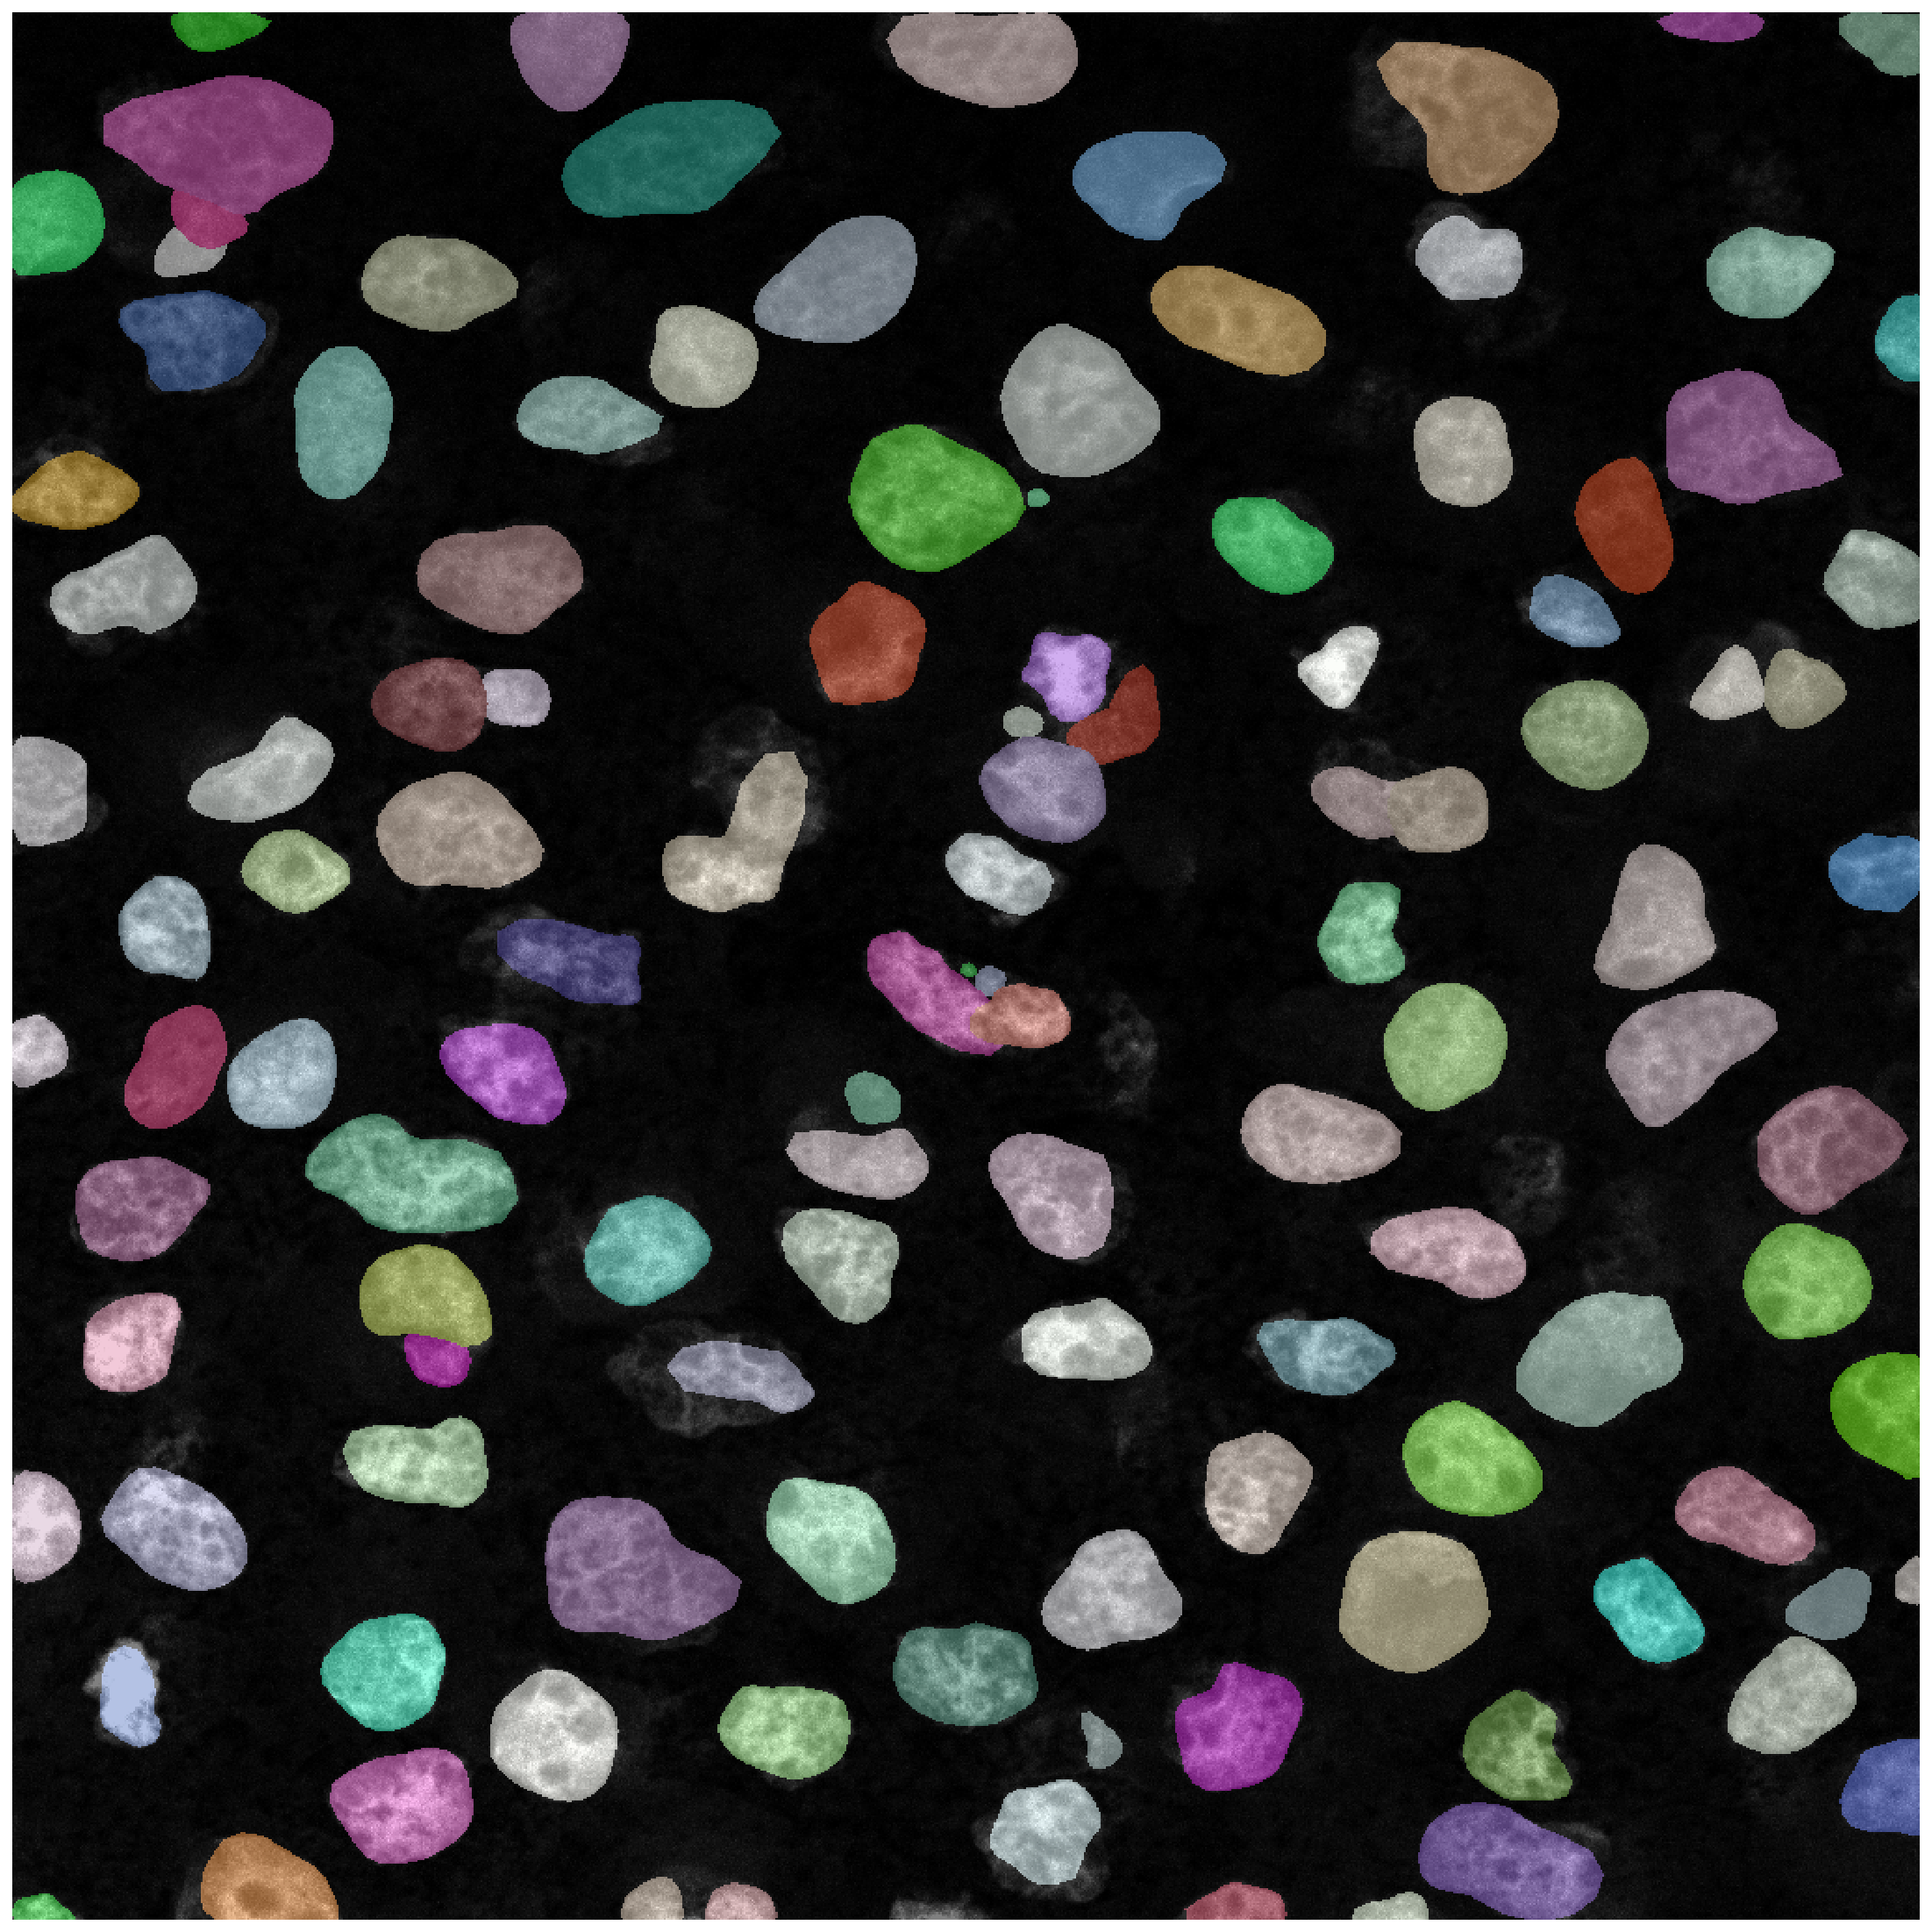

In [32]:
plt.figure(figsize=(20,20))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

model need to be compiled again after setting the trainable state

In [12]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, grid=model.config.grid, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

## load pretrained model

In [24]:
# load weights into current model in h5 format (keras)
model.keras_model.load_weights("tune_a1_xenopus/stardist_tune/weights_last.h5")
print("Loaded model from disk")

Loaded model from disk


In [13]:
# load weights into current model in h5 format (keras)
model.keras_model.load_weights("../../models/stardist_depth_3_augment_True_grid_2_2_epochs_800/weights_last.h5")
print("Loaded model from disk")

Loaded model from disk


In [14]:
conf

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_one_cycle_lr_max=0.003, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0, 'verbose': True}, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False, y_range

In [15]:
AUGMENTATIONS_TRAIN

Compose([
  Flip(always_apply=False, p=0.5),
  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(-0.0625, 0.0625), scale_limit=(0.5, 0.10000000000000009), rotate_limit=(-45, 45), interpolation=0, border_mode=4, value=None, mask_value=None),
  Downscale(always_apply=False, p=0.5, scale_min=0.25, scale_max=0.25, interpolation=0),
  ElasticTransform(always_apply=False, p=0.5, alpha=1000, sigma=100, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None, approximate=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

## Test LRFinder 

In [98]:
# model is a Keras model
lr_finder = LRFinder(model.keras_model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(data_train, start_lr=1e-8, end_lr=1.0)

Epoch 1/13
8/8 [==============================] - 39s 5s/step - loss: 0.4211 - prob_loss: 0.0819 - dist_loss: 1.6961 - prob_kld: 0.0075 - dist_relevant_mae: 1.6956 - dist_relevant_mse: 10.5673
Epoch 2/13
1/8 [==>...........................] - ETA: 24s - loss: 0.3900 - prob_loss: 0.0809 - dist_loss: 1.5454 - prob_kld: 0.0080 - dist_relevant_mae: 1.5450 - dist_relevant_mse: 6.0112

Min. loss grad point, lr: 1.4454397678775877e-08, loss: 0.42443979530817066


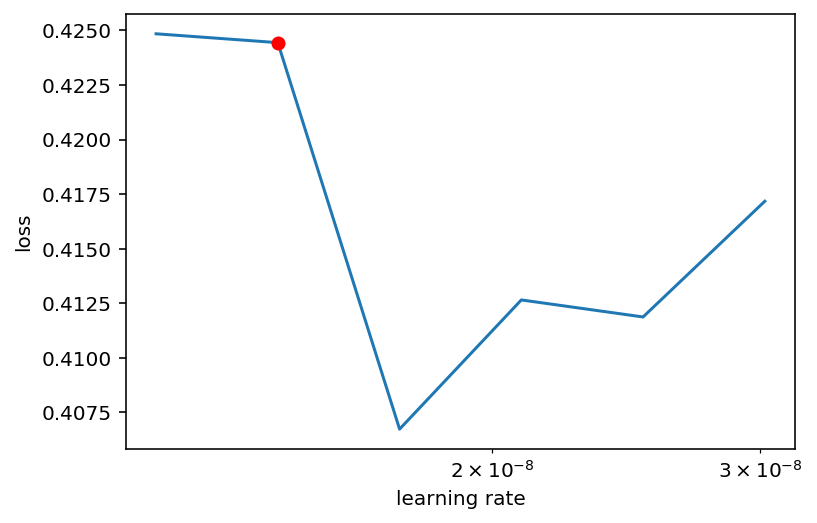

In [99]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(skip_start=1, skip_end=1, suggestion=True)

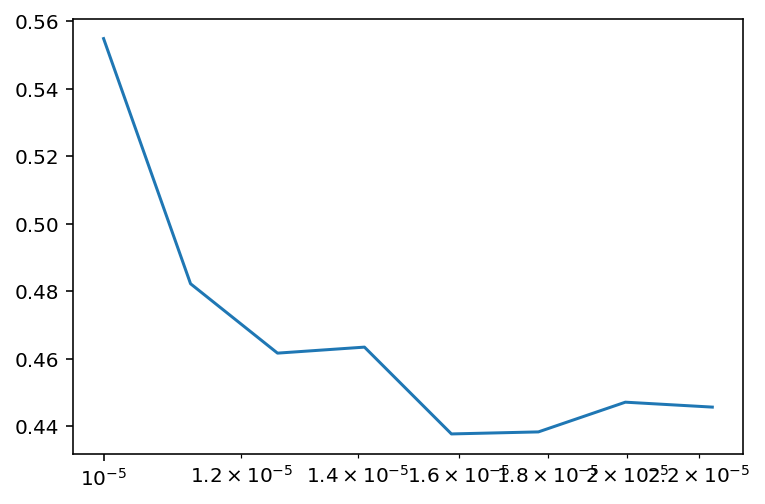

In [80]:
plt.plot(lr_finder.lrs, lr_finder.losses)
plt.xscale('log')

## Start training

In [ ]:
# %debug
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=AUGMENTATIONS_TRAIN)

Epoch 1/400
100/100 [==============================] - 67s 671ms/step - loss: 3.7623 - prob_loss: 0.2273 - dist_loss: 17.6752 - prob_kld: 0.0805 - dist_relevant_mae: 17.6720 - dist_relevant_mse: 467.1629 - val_loss: 2.9208 - val_prob_loss: 0.2416 - val_dist_loss: 13.3959 - val_prob_kld: 0.0449 - val_dist_relevant_mae: 13.3938 - val_dist_relevant_mse: 259.3913
- OneCycleScheduler, lr: 0.00012049345203519763
Epoch 2/400
100/100 [==============================] - 63s 635ms/step - loss: 2.9083 - prob_loss: 0.2276 - dist_loss: 13.4031 - prob_kld: 0.0801 - dist_relevant_mae: 13.4007 - dist_relevant_mse: 308.2310 - val_loss: 2.1216 - val_prob_loss: 0.2480 - val_dist_loss: 9.3676 - val_prob_kld: 0.0513 - val_dist_relevant_mae: 9.3657 - val_dist_relevant_mse: 140.3536
- OneCycleScheduler, lr: 0.0001219734699534139
Epoch 3/400
100/100 [==============================] - 66s 661ms/step - loss: 2.3922 - prob_loss: 0.2296 - dist_loss: 10.8129 - prob_kld: 0.0816 - dist_relevant_mae: 10.8109 - dist_re

In [11]:
model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, None, None, 3 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

# Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [25]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:03<00:00,  4.67it/s, 0.448 -> 0.826]


Using optimized values: prob_thresh=0.446925, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.4469253420829773, 'nms': 0.3}

In [18]:
%pwd

'/home/qzt/stardist/examples/2D'

In [26]:
model.export_TF(fname='tune_a1_xenopus')